# FRUIT OBJECT DETECTION USING YOLO

### 1. Extracting the Object Information from XML file

In [59]:
#importing libraries
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from functools import reduce
from xml.etree import ElementTree as et
from shutil import move
import yaml
from yaml.loader import SafeLoader
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Extracting the xml files from the dataset and storing it in list
xml_list = glob('/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/*.xml')

In [3]:
xml_list[:5]

['/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/orange_70.xml',
 '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/banana_34.xml',
 '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/orange_59.xml',
 '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/banana_21.xml',
 '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits/orange_71.xml']

### Extracting key elements from xml file
- filename
- size(width, height)
- object(name, xmin, xmax, ymin, ymax)



In [4]:
def extract_object_info(filename):
  tree = et.parse(filename)
  root = tree.getroot()

  parser = []

  # 1. Extracting thef filename
  image_name = root.find('filename').text

  # 2. Extracting the width and height of the image
  width = root.find('size').find('width').text
  height = root.find('size').find('height').text

  # 3. Extracting name, xmin, xmax, ymin, ymax
  objects = root.findall('object')
  for obj in objects:
    name = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = bndbox.find('xmin').text
    xmax = bndbox.find('xmax').text
    ymin = bndbox.find('ymin').text
    ymax = bndbox.find('ymax').text
    parser.append([image_name, width, height, name, xmin, xmax, ymin, ymax])
  return parser

parser_all = list(map(extract_object_info, xml_list))

In [5]:
parser_all[:5]

[[['orange_70.jpg', '0', '0', 'orange', '368', '706', '109', '470'],
  ['orange_70.jpg', '0', '0', 'orange', '58', '410', '69', '432']],
 [['banana_34.jpg', '300', '318', 'banana', '63', '273', '48', '310']],
 [['orange_59.jpg', '0', '0', 'orange', '2', '203', '94', '299']],
 [['banana_21.jpg', '780', '439', 'banana', '174', '607', '62', '387'],
  ['banana_21.jpg', '780', '439', 'banana', '322', '696', '77', '439'],
  ['banana_21.jpg', '780', '439', 'banana', '116', '555', '48', '293']],
 [['orange_71.jpg', '1400', '1249', 'orange', '134', '896', '208', '943']]]

In [6]:
#Flattening this parser_all data using Reduce
data = reduce(lambda x, y : x + y, parser_all)

In [7]:
data[:5]

[['orange_70.jpg', '0', '0', 'orange', '368', '706', '109', '470'],
 ['orange_70.jpg', '0', '0', 'orange', '58', '410', '69', '432'],
 ['banana_34.jpg', '300', '318', 'banana', '63', '273', '48', '310'],
 ['orange_59.jpg', '0', '0', 'orange', '2', '203', '94', '299'],
 ['banana_21.jpg', '780', '439', 'banana', '174', '607', '62', '387']]

Now the data is in row and column format i.e 2-D Format.<br> The first columns is the 'filename'<br> The second column is the 'width'<br>The third column is the 'height'<br>The fourth column is the 'name'<br>The fifth column is the 'xmin'<br>The sixth column is the 'xmax'<br>The seventh column is the 'ymin'<br>The eight column is the 'ymax'

In [8]:
# converting this information in dataframe format
df = pd.DataFrame(data, columns = ['filename', 'width', 'height', 'name', 'xmin', 'xmax', 'ymin', 'ymax'])

In [9]:
df.shape

(478, 8)

In [10]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax
0,orange_70.jpg,0,0,orange,368,706,109,470
1,orange_70.jpg,0,0,orange,58,410,69,432
2,banana_34.jpg,300,318,banana,63,273,48,310
3,orange_59.jpg,0,0,orange,2,203,94,299
4,banana_21.jpg,780,439,banana,174,607,62,387


In [11]:
print(f'Unique Categories : {df["name"].unique()}')

Unique Categories : ['orange' 'banana' 'apple']


In [12]:
df['name'].value_counts()

name
banana    175
apple     157
orange    146
Name: count, dtype: int64

### 2. Preparing labels for YOLO model

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  478 non-null    object
 1   width     478 non-null    object
 2   height    478 non-null    object
 3   name      478 non-null    object
 4   xmin      478 non-null    object
 5   xmax      478 non-null    object
 6   ymin      478 non-null    object
 7   ymax      478 non-null    object
dtypes: object(8)
memory usage: 30.0+ KB


In [14]:
#type conversion
cols = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df[cols] = df[cols].astype('int')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  478 non-null    object
 1   width     478 non-null    int64 
 2   height    478 non-null    int64 
 3   name      478 non-null    object
 4   xmin      478 non-null    int64 
 5   xmax      478 non-null    int64 
 6   ymin      478 non-null    int64 
 7   ymax      478 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 30.0+ KB


Converting the bounding box(bbox) information in the YOLO labels

In [16]:
# applying formulas

df['center_x'] = ((df['xmin'] + df['xmax'])/2)/df['width']
df['center_y'] = ((df['ymin'] + df['ymax'])/2)/df['height']
df['w'] = (df['xmax'] - df['xmin'])/df['width']
df['h'] = (df['ymax'] - df['ymin'])/df['height']

In [17]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,orange_70.jpg,0,0,orange,368,706,109,470,inf,inf,inf,inf
1,orange_70.jpg,0,0,orange,58,410,69,432,inf,inf,inf,inf
2,banana_34.jpg,300,318,banana,63,273,48,310,0.560000,0.562893,0.700000,0.823899
3,orange_59.jpg,0,0,orange,2,203,94,299,inf,inf,inf,inf
4,banana_21.jpg,780,439,banana,174,607,62,387,0.500641,0.511390,0.555128,0.740319


### 3. Train test Split

In [18]:
images = df['filename'].unique()
len(images)

240

In [19]:
img_df = pd.DataFrame(images, columns = ['filename'])

In [20]:
img_df.head()

,filename
0,orange_70.jpg
1,banana_34.jpg
2,orange_59.jpg
3,banana_21.jpg
4,orange_71.jpg


In [21]:
# 80 - 20 ratio
img_train = tuple(img_df.sample(frac = 0.8)['filename'])   #shuffle and pick random 80% images

In [22]:
img_train[:5]

('apple_27.jpg',
 'orange_36.jpg',
 'orange_12.jpg',
 'banana_30.jpg',
 'banana_43.jpg')

In [23]:
img_test = tuple(img_df.query(f'filename not in {img_train}')['filename']) #rest 20% images

In [24]:
img_test[:5]

('banana_3.jpg',
 'apple_12.jpg',
 'orange_73.jpg',
 'apple_13.jpg',
 'apple_22.jpg')

In [25]:
len(img_train), len(img_test)

(192, 48)

In [26]:
train_df = df.query(f'filename in {img_train}')
test_df = df.query(f'filename in {img_test}')

In [27]:
train_df.head(3)

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,orange_70.jpg,0,0,orange,368,706,109,470,inf,inf,inf,inf
1,orange_70.jpg,0,0,orange,58,410,69,432,inf,inf,inf,inf
2,banana_34.jpg,300,318,banana,63,273,48,310,0.56,0.562893,0.7,0.823899


In [28]:
test_df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
12,banana_3.jpg,768,511,banana,180,647,161,436,0.538411,0.584149,0.608073,0.538160
13,banana_3.jpg,768,511,banana,190,623,100,330,0.529297,0.420744,0.563802,0.450098
17,apple_12.jpg,450,428,apple,43,350,21,353,0.436667,0.436916,0.682222,0.775701
18,orange_73.jpg,1024,768,orange,191,853,43,746,0.509766,0.513672,0.646484,0.915365
40,apple_13.jpg,800,800,apple,415,720,261,567,0.709375,0.517500,0.381250,0.382500


### 4. Label Encoding (Converting the object name to unique ID's)

In [29]:
print(f'Unique Categories : {df["name"].unique()}')

Unique Categories : ['orange' 'banana' 'apple']


In [30]:
def label_encoding(x):
    labels = {'apple' : 0, 'orange' : 1, 'banana' : 2}
    return labels[x]

train_df['id'] = train_df['name'].apply(label_encoding)
test_df['id'] = test_df['name'].apply(label_encoding)

In [31]:
train_df.head(3)

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h,id
0,orange_70.jpg,0,0,orange,368,706,109,470,inf,inf,inf,inf,1
1,orange_70.jpg,0,0,orange,58,410,69,432,inf,inf,inf,inf,1
2,banana_34.jpg,300,318,banana,63,273,48,310,0.56,0.562893,0.7,0.823899,2


In [32]:
test_df.head(3)

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h,id
12,banana_3.jpg,768,511,banana,180,647,161,436,0.538411,0.584149,0.608073,0.538160,2
13,banana_3.jpg,768,511,banana,190,623,100,330,0.529297,0.420744,0.563802,0.450098,2
17,apple_12.jpg,450,428,apple,43,350,21,353,0.436667,0.436916,0.682222,0.775701,0


In [33]:
train_df['id'].unique()

array([1, 2, 0])

### 5. Creating Folder Structure

- Images (jpg format)
- labels (.txt format)


In [34]:
train_folder = '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/train'
test_folder = '/content/drive/MyDrive/Fruit_Object_Detection/Dataset/test'

os.mkdir(train_folder)
os.mkdir(test_folder)

In [35]:
cols = ['filename', 'id','center_x', 'center_y', 'w', 'h']

groupby_obj_train = train_df[cols].groupby('filename')
groupby_obj_test = test_df[cols].groupby('filename')

In [36]:
groupby_obj_train

In [37]:
#save each image in train or test folder and respective labels in .txt file
def save_data(filename, folder_path, group_obj):
    source = os.path.join('/content/drive/MyDrive/Fruit_Object_Detection/Dataset/Fruits', filename)
    destination = os.path.join(folder_path, filename)
    move(source, destination) #move images to the destination folder from source folder

    #saving the labels information

    #seperating the extension from filename (At 0th index we have filename and appending 'txt' extention to it)
    text_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '.txt')
    group_obj.get_group(filename).set_index('filename').to_csv(text_filename, sep = ' ' ,index = False, header = False)


In [38]:
filename_series = pd.Series(groupby_obj_train.groups.keys())

In [39]:
filename_series

0        apple_1.jpg
1       apple_11.jpg
2       apple_14.jpg
3       apple_15.jpg
4       apple_16.jpg
           ...      
187    orange_74.jpg
188    orange_75.jpg
189    orange_76.jpg
190     orange_8.jpg
191     orange_9.jpg
Length: 192, dtype: object

In [40]:
filename_series.apply(save_data, args = (train_folder, groupby_obj_train))

0      None
1      None
2      None
3      None
4      None
       ... 
187    None
188    None
189    None
190    None
191    None
Length: 192, dtype: object

In [41]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data, args = (test_folder, groupby_obj_test))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
dtype: object

### 6. Creating YAML files

Specifying train and val set, class label and object names into that

In [42]:
os.chdir('/content/drive/MyDrive/Fruit_Object_Detection')

In [43]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16858, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 16858 (delta 19), reused 35 (delta 6), pack-reused 16805 (from 1)
Receiving objects: 100% (16858/16858), 15.54 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (11557/11557), done.
Updating files: 100% (148/148), done.


In [44]:
os.chdir('yolov5')

In [45]:
ls

benchmarks.py    data/       LICENSE         README.zh-CN.md   tutorial.ipynb
CITATION.cff     detect.py   models/         requirements.txt  utils/
classify/        export.py   pyproject.toml  segment/          val.py
CONTRIBUTING.md  hubconf.py  README.md       train.py


In [46]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

### 7. Training YOLO model

In [47]:
#training yolov5 model
!python train.py --data data.yaml --cfg yolov5s.yaml --batch-size 8 --name Model --epochs 50

2024-08-21 06:28:01.596507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 06:28:01.596574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 06:28:01.714691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=F

Weights are saved in pyTorch Format<br>
As we want to work with opencv we'll convert them to 'onnx' format<br>
From yolov5 -> export.py file

In [48]:
!python export.py --weights runs/train/Model/weights/best.pt --include torchscript onnx

export: data=data/coco128.yaml, weights=['runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-356-g2070b303 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/Model/weights/best.pt with output shape (1, 25200, 8) (13.8 MB)

TorchScript: starting export with torch 2.3.1+cu121...
TorchScript: export success ✅ 3.3s, saved as runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 180.0 MB/s eta 0:00:

### 8. Testing on Images

In [51]:
#load yaml
with open('data.yaml', mode = 'r') as f:
  data_yaml = yaml.load(f, Loader = SafeLoader)

labels = data_yaml['names']
print(labels)

['apple', 'orange', 'banana']


In [54]:
#load yolo model
yolo = cv2.dnn.readNetFromONNX('/content/drive/MyDrive/Fruit_Object_Detection/yolov5/runs/train/Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [62]:
#loading the image and get predictions
IMG = cv2.imread('/content/fruit_img.jpg')
image = IMG.copy()

#displaying the image
# from google.colab.patches import cv2_imshow
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

row, col, d = image.shape

# STEP - 1 : converting the image into square matrix
max_rc = max(row, col)
input_img = np.zeros((max_rc, max_rc, 3), dtype = np.uint8)
#overlaying out image on the black image
input_img[0:row, 0:col] = image


# STEP 2 : Passing this square array to yolo model
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_img, 1/255, (INPUT_WH_YOLO, INPUT_WH_YOLO), swapRB = True, crop = False)
yolo.setInput(blob)
preds = yolo.forward()  #getting detection from yolo model

In [64]:
print(preds.shape)

(1, 25200, 8)


25200 are the no.of bounding boxes detected by yolo model<br>
Info of those 25200 bbox is stored in 8 columns

## 9. Non Maximum Suppression

To remove duplicate detections

In [69]:
# STEP 1 : Filter Detection based on confidence (0.4) and propbability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

img_w, img_h = input_img.shape[:2]
x_factor = img_w/INPUT_WH_YOLO
y_factor = img_h/INPUT_WH_YOLO

for i in range(len(detections)):
  row = detections[i]
  confidence = row[4]  #4th row
  if confidence > 0.4:
    class_score = row[5:].max() #max probability from 3 objects
    class_id = row[5:].argmax() # get the index position at which the maximum probability occurs

    if class_score > 0.25:
      cx, cy, w, h = row[0:4]
      #constructing the bounding box(bbox) from this four values
      # left, top, width, and height
      left = int((cx - 0.5*w)*x_factor)
      top = int((cy - 0.5*h)*y_factor)
      width = int(w*x_factor)
      height = int(h*y_factor)

      box = np.array([left, top, width, height])

      confidences.append(confidence)
      boxes.append(box)
      classes.append(class_id)

In [70]:
confidences[:5]

[0.58925563, 0.6571136, 0.55793124, 0.80001366, 0.45867002]

In [71]:
classes[:5]

[2, 2, 2, 1, 1]

In [72]:
# clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()


#NonMaximumSupression(NMS)
index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45).flatten()

In [74]:
index

array([77, 35, 75, 52, 55, 90, 82, 73, 65, 63, 67], dtype=int32)

Out of 25200 rows we only need to find this ([77, 35, 75, 52, 55, 90, 82, 73, 65, 63, 67]) detections

In [75]:
len(index)

11

### 10. Drawing bounded boxes (bbox)

In [77]:
for ind in index:
  #extracting bounding box
  x, y, w, h = boxes_np[ind]
  bb_conf = int(confidences_np[ind] * 100)
  classes_id = classes[ind]
  class_name = labels[classes_id]

  text = f'{class_name} : {bb_conf}%'
  # print(text)

  cv2.rectangle(image, (x,y), (x+w, y+h), (0, 255, 0), 2)
  cv2.rectangle(image, (x,y-30), (x+w, y), (255,255,255), -1)
  cv2.putText(image, text, (x,y - 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,0,0), 1)

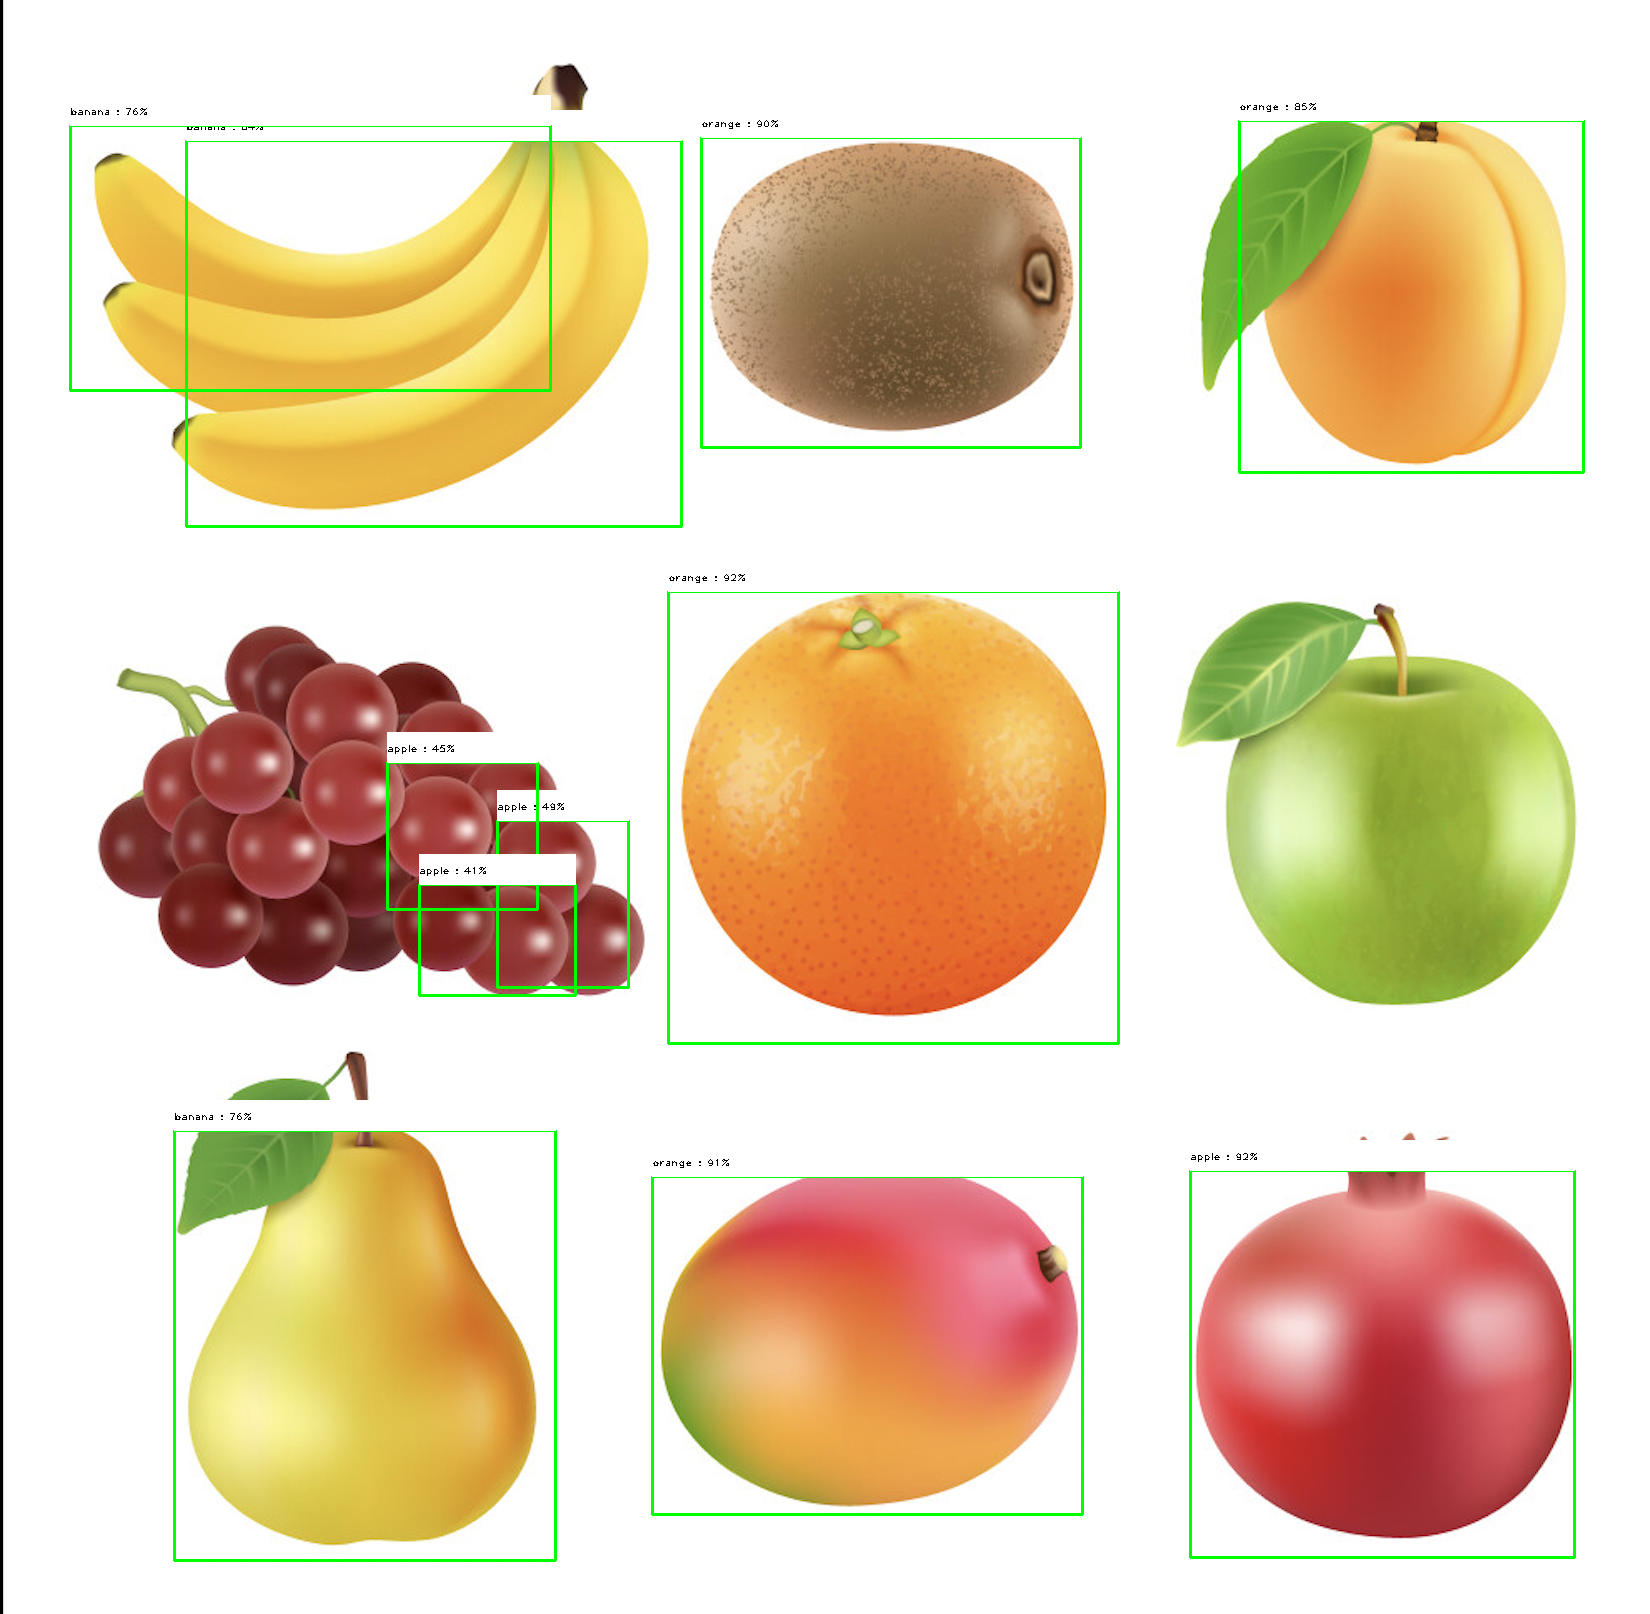

In [78]:
from google.colab.patches import cv2_imshow
# cv2_imshow(IMG) #original image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()